In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !pip install pycocotools
# !pip install --upgrade pip
# # !python3 -m pip  install --user 'git+https://github.com/facebookresearch/detectron2.git'
# !python -m pip install pyyaml==5.1
# import sys, os, distutils.core
# # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))


'''Inspired from  EVALAI AVA Challenge starter training files'''

import os
import cv2
import json
import random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators
from loss import * 
from model import *

# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

# Setup logger
setup_logger()


<Logger detectron2 (DEBUG)>

In [2]:
DatasetCatalog.clear()
Data_Resister_training="../Data_NoTemporal_cleaned_orig/train_xworld";
Data_Resister_valid="../Data_NoTemporal_cleaned_orig/val_xworld/";
from detectron2.data.datasets import register_coco_instances

register_coco_instances(Data_Resister_training,{}, '../Data_NoTemporal_cleaned_orig/train_xworld.json', Path("../Data_NoTemporal_cleaned_orig/train_xworld"))
register_coco_instances(Data_Resister_valid,{},'../Data_NoTemporal_cleaned_orig/val_xworld.json', Path("../Data_NoTemporal_cleaned_orig/val_xworld"))

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[06/08 13:31:34 d2.data.datasets.coco]: Loading ../Data_NoTemporal_cleaned_orig/train_xworld.json takes 3.20 seconds.
[06/08 13:31:34 d2.data.datasets.coco]: Loaded 18806 images in COCO format from ../Data_NoTemporal_cleaned_orig/train_xworld.json
[06/08 13:31:37 d2.data.datasets.coco]: Loading ../Data_NoTemporal_cleaned_orig/val_xworld.json takes 1.04 seconds.
[06/08 13:31:37 d2.data.datasets.coco]: Loaded 4225 images in COCO format from ../Data_NoTemporal_cleaned_orig/val_xworld.json


image name:../Data_NoTemporal_cleaned_orig/train_xworld/010000047135.jpg
image name:../Data_NoTemporal_cleaned_orig/train_xworld/010000019659.jpg
image name:../Data_NoTemporal_cleaned_orig/train_xworld/030000068419.jpg


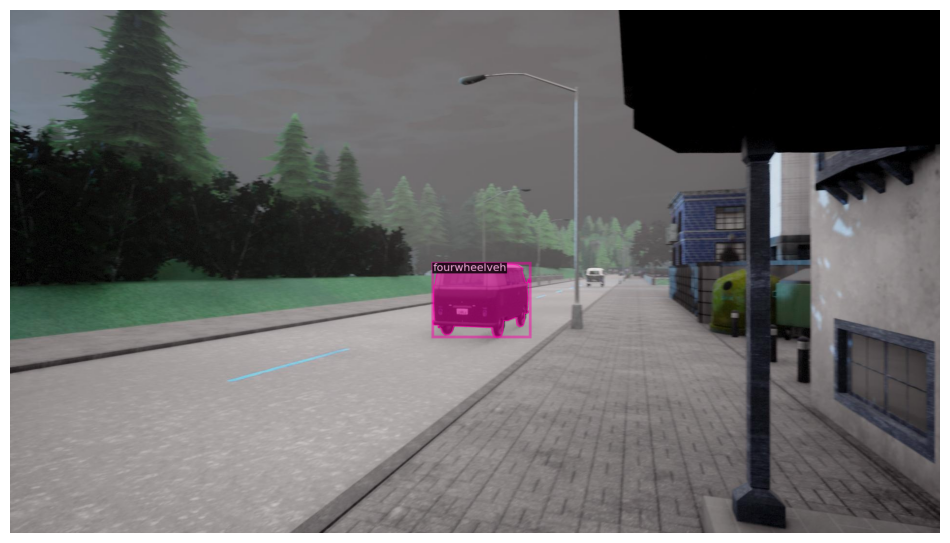

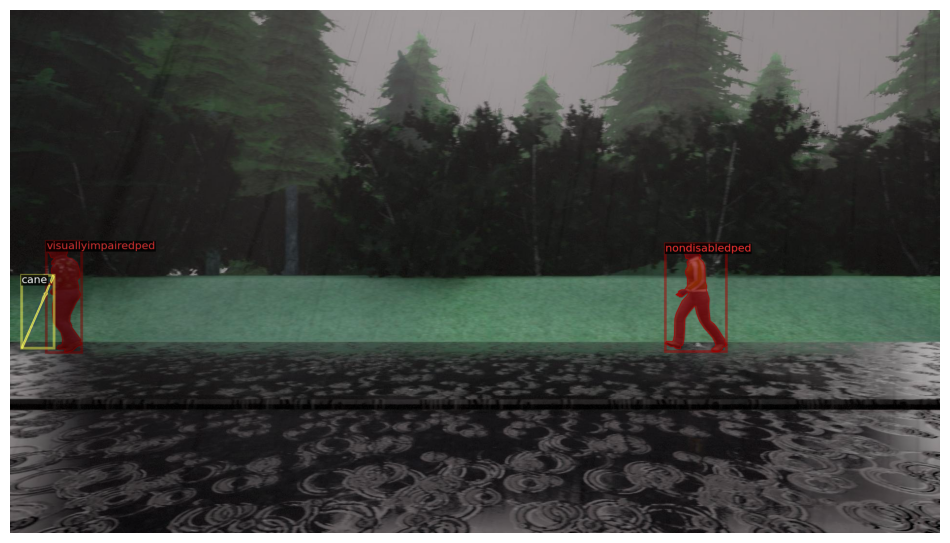

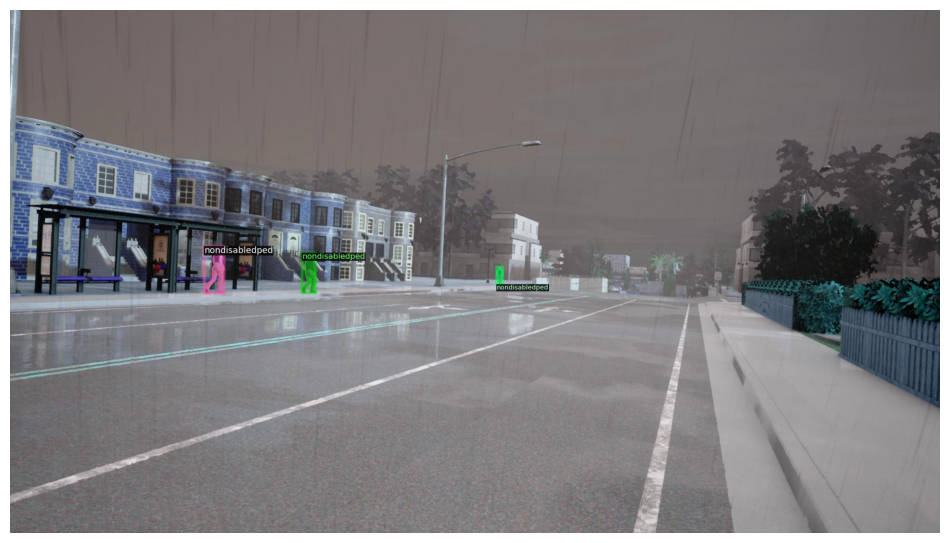

In [3]:
for i in random.sample(range(len(dataset_train)), k=3):
    sample = dataset_train[i]

    fig, ax = plt.subplots(figsize =(12,8))
    img = cv2.imread(sample["file_name"])
    v = Visualizer(
            img[:, :, ::-1],
            metadata=metadata, 
            instance_mode=ColorMode.IMAGE_BW
        )
    
    for s in sample["annotations"]:
        if 'keypoints' in s.keys():
            s.pop("keypoints", None)
            
    out = v.draw_dataset_dict(sample)
    ax.axis('off')
    print(f"image name:{sample['file_name']}")
    ax.imshow(out.get_image()[:, :, ::-1])

In [4]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return DatasetEvaluators([COCOEvaluator(dataset_name, output_dir=output_folder)])

In [5]:

cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
        # "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8 
cfg.MODEL.MASK_ON = True
cfg.MODEL.DEVICE = "cpu"

cfg.DATALOADER.NUM_WORKERS = 8

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.01 
cfg.SOLVER.WARMUP_ITERS = 10 
cfg.SOLVER.MAX_ITER = 5000

cfg.SOLVER.STEPS = (200, 600)
cfg.SOLVER.CHECKPOINT_PERIOD=200

cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.PIXEL_MEAN = [103.530, 116.280, 123.675]
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV=4
cfg.OUTPUT_DIR = "./segmentation"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
cfg.MODEL.ROI_MASK_HEAD.NAME='MaskRCNNConvUpsampleHead_multi'

In [7]:
from detectron2.modeling import roi_heads

roi_heads.mask_head.mask_rcnn_loss = mask_rcnn_loss_

In [8]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

LOADING MULTIHEAD ATTENTION MaskRCNN
[06/08 13:31:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, ep

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[06/08 13:31:57 d2.engine.train_loop]: Starting training from iteration 0
[06/08 13:44:06 d2.utils.events]:  eta: 2 days, 2:16:11  iter: 19  total_loss: 1.773  loss_cls: 0.5467  loss_box_reg: 0.4761  loss_mask: 0.4262  loss_rpn_cls: 0.0863  loss_rpn_loc: 0.2355    time: 36.0940  last_time: 34.8292  data_time: 0.0986  last_data_time: 0.0090   lr: 0.01  
[06/08 13:45:23 d2.engine.hooks]: Overall training speed: 19 iterations in 0:12:07 (38.2664 s / it)
[06/08 13:45:23 d2.engine.hooks]: Total training time: 0:12:07 (0:00:00 on hooks)
[06/08 13:45:23 d2.utils.events]:  eta: 2 days, 2:17:18  iter: 21  total_loss: 1.691  loss_cls: 0.5137  loss_box_reg: 0.4956  loss_mask: 0.421  loss_rpn_cls: 0.0863  loss_rpn_loc: 0.2355    time: 36.1391  last_time: 36.9511  data_time: 0.0090  last_data_time: 0.0048   lr: 0.01  


In [ ]:
predictor = DefaultPredictor(cfg)

# Access the model
model = predictor.model

# Set the model to evaluation mode
model.eval()

In [ ]:
''' Count Traininable Parameters'''


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")